# In this assignment, a simple ConvNet is implemented and trained to predict the language of a surname from its spelling in English.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import block_diag
from scipy.io import loadmat

## 1. ConvNet class implementation

In [30]:
class ConvNet:
    """
    A simple ConvNet implementation with 2 convolutional layers 
    followed by a fully connected layer and a softmax output 
    layer.
    
    Attributes:
        n: A list of the number of filters applied at each convo-
            lutional layer.
        k: A list of the width of the filter window applied in each
            convolutional layer.
        input_dim: dimensionality of input (number of unique characters)
        output_dim: dimensionality of output
        max_length: maximum number of characters in an input
        nlen_list: List with the number of columns of the input when in its original form
            before being vectorized, for each layer.
        eta: initial learning rate value
        rho: momentum constant term
        F: list of filters/weights for each one of the convolutional
            layers.
        W: Weights of the fully connected layer
        
    """
    
    def __init__(self, n, k, output_dim, input_dim, nlen, eta = 0.001, rho = 0.9, he_init = False):
        """
        Initializes the convolutional neural network
    
        Args:
            he_init: When True He-initialization is performed for the weights
            nlen: Number of columns of the input when in its original form
            before being vectorized.
        Raises:
            Exception if the size of n and k is not the same.
        """
        if(len(n) != len(k)):
            raise Exception("The number of layers specified by <n> " \
                            "and <k> should be equal.")
        self.n = list(n)
        self.k = list(k)
        
        self.input_dim = input_dim
        self.max_length = nlen
        
        # TODO: Change He initialization for first layer due to the sparse nature of the input
        self.F = []
        if he_init is True:
            self.F.append(np.random.normal(0, np.sqrt(2/nlen), (input_dim, self.k[0], self.n[0])))
        else:
            self.F.append(np.random.normal(0, 1, (input_dim, self.k[0], self.n[0])))
        self.nlen_list = [nlen - self.k[0] + 1]
        
        for i in range(1, len(n)):
            if he_init is True:
                self.F.append(np.random.normal(0, np.sqrt(2/self.nlen_list[-1]), (self.n[i - 1], self.k[i], self.n[i])))
            else:
                self.F.append(np.random.normal(0, 1, (self.n[i - 1], self.k[i], self.n[i])))
            self.nlen_list.append(self.nlen_list[-1] - self.k[1] + 1)
        fsize = self.n[-1] * self.nlen_list[-1]
        if he_init is True:
            self.W = np.random.normal(0, np.sqrt(2/self.nlen_list[-1]), (output_dim, fsize))
        else:
            self.W = np.random.normal(0, 1, (output_dim, fsize))
    
    def softmax(self, s):
        """
        Implementation of the softmax activation function

        Args:
            s: an 1xd vector of a classifier's outputs

        Returns:
            An 1xd vector with the results of softmax given the input
            vector s.
        """
        exponents = np.exp(s - np.max(s, axis = 0)) # Max subtraction for numerical stability
        output_exp_sum = np.sum(exponents, axis = 0)
        p = exponents / output_exp_sum
        return p

    def constructFilterMatrix(self, F, nlen):
        """
        Constructs the matrix of the filters of a layer used to
        perform the convolution by matrix multiplication.
        
        Args:
            F: A N x k x nf containing the convolutional filters
                of a certain layer where N is the height of the convo-
                lutional filter, k is its width and nf is the number of
                filters in the layer.
            nlen: Number of columns in the input of that layer. 
        
        Returns:
            An (nlen - k + 1) * nf x nlen * N matrix that can be used to
            perform the convolution when multiplied by the
            vectorized input.
        """
        nf = F.shape[2]
        vec_filters = F.transpose(2,1,0).reshape(nf, F.shape[0] * F.shape[1])
        MF_matrix = np.zeros(((nlen - F.shape[1] + 1) * nf, nlen * F.shape[0]))
        cur_column = 0
        # For each time the filters are applied
        for i in range(nlen - F.shape[1] + 1):
            # Fill in the zero slots of the MF_Matrix with the vectorized filters
            MF_matrix[i * nf: i * nf + nf, cur_column *  F.shape[0]: cur_column *  F.shape[0] + vec_filters.shape[1]] = vec_filters
            cur_column += 1
        return MF_matrix
        
    def makeMXMatrix(self, vec_input, height, width, nf, nlen):
        """
        Computes the input matrix used for the convolutions during the 
        back-propagation.
        
        Args:
            vec_input: Vectorized version of the input to the convolutional
                layer.
            height: corresponding height of the filter
            width: corresponding width of the filter
            filter_no: number of filters to be applied
            nlen: Number of columns in the input of that layer. 
        Returns:
            A (nlen - k + 1) * filter_no x k * filter_no * height with the
            results of the convolutions.
        """
        MX_Matrix = np.zeros(((nlen - width + 1) * nf, width * nf * height))
        cur_column = 0
        for i in range(nlen - width + 1):
            # Define block diagonal matrix with the inputs to be used in this convolution on the diagonal
            MX_Matrix[i * nf : i * nf + nf, :] = \
                block_diag(*[vec_input[cur_column * height: cur_column * height + width * height] for j in range(nf)]) 
            cur_column += 1
        return MX_Matrix
    
    def cross_entropy_loss(self, X, Y, MFs):
        """
        Calculates the cross entropy loss
        """
        log_X = np.multiply(Y , self.forwardPass(X, MFs)[0]).sum(axis=0)
        log_X[log_X == 0] = np.finfo(float).eps
        return -np.log(log_X)

    
    def computeLoss(self, X_batch, Y_batch, MFs):
        """
        Computes the loss of the network given a batch of data.
        
        Args:
            X_batch: NxD matrix with N data sample inputs
            Y_batch: NxM matrix with N data sample outputs
        
        Returns:
            A scalar float value corresponding to the loss.
        """        
        return np.mean(self.cross_entropy_loss(X_batch, Y_batch, MFs))# + lamda * np.sum(self.W ** 2)

    def computeAccuracy(self, X, y, MFs):
        """
        Computes the accuracy of the network.

        Args:
            X: Input matrix
            y: Output labels

        Returns:
            The accuracy of the network (i.e. the percentage of
            correctly classified inputs in X).

        """
        softmax_outputs = self.forwardPass(X, MFs)[0] # Get probability distribution of outputs
        # Reduce to a vector of the labels with the highest probability
        predictions = np.argmax(softmax_outputs, axis = 0)
        accuracy = (predictions == y).mean()
        return accuracy

    def forwardPass(self, X_batch, MFs):
        """
        Performs a forward pass and returns the result:
        
        Args:
            X_batch: NxD matrix with N data sample inputs
            MFs: Matrices needed to perform convolution as 
                matrix multiplication.
            
        Returns:
            A matrix with the predicted one-hot representations along with the outputs
            of the first and second layer as well as the MF matrices calculated.
        """
        
        # Apply first convolutional layer to input data followed by a ReLU activation
        X_batch1 = MFs[0].dot(X_batch)
        X_batch1[X_batch1 < 0.0] = 0.0
        
        # Apply second convolutional layer to input data followed by a ReLU activation
        X_batch2 = MFs[1].dot(X_batch1)
        X_batch2[X_batch2 < 0.0] = 0.0
        
        # Apply the fully connected layer
        output = self.W.dot(X_batch2)
        # Apply softmax
        P_batch = self.softmax(output)
        return P_batch, X_batch1, X_batch2
    
    def backwardPass(self, Y_batch, P_batch, X_batch, X_batch1, X_batch2, MFs):
        """
        Performs a backward pass and returns the gradients:
        
        Args:
            Y_batch: NxM matrix with N data sample outputs
            P_batch: Output after the softmax activation layer
            X_batch2: Output of the second convolutional layer after the ReLU.
            X_batch1: Output of the first convolutional layer after the ReLU.
            X_batch: Original batch with the inputs.
            MFs: Matrices needed to perform convolution as 
                matrix multiplication.
            
        Returns:
            The gradients of the weights of each layer (i.e. grad_F1, grad_F2, grad_W).
        """
        # Initialize all gradients to zero
        grad_W = np.zeros(self.W.shape) 
        grad_F1 = np.zeros(self.F[0].shape)
        grad_F2 = np.zeros(self.F[1].shape)
        
        # Compute gradient of W
        n = Y_batch.shape[1]
        G_batch = -(Y_batch - P_batch)
        grad_W = G_batch.dot(X_batch2.T) / n
        
        
        # Propagate gradient through fully connected layer and ReLU of 2nd layer
        G_batch = self.W.T.dot(G_batch)
        G_batch *= np.where(X_batch2 > 0, 1, 0)
        
        # Compute gradient of the second layer's filters
        n = X_batch1.shape[1]
        for j in range(n):
            g_j = G_batch[:,j]
            x_j = X_batch1[:,j]
            MX_matrix = self.makeMXMatrix(x_j, *self.F[1].shape, self.nlen_list[0])
            v = g_j.T.dot(MX_matrix)
            grad_F2 += v.reshape(grad_F2.shape, order='F')
        grad_F2 /= n
        
        # Propagate gradient through second convolutional layer and ReLU of 1st layer
        G_batch = MFs[1].T.dot(G_batch)
        G_batch *= np.where(X_batch1 > 0, 1, 0)
        
        # Compute gradient of the first layer's filters
        n = X_batch.shape[1]
        for j in range(n):
            g_j = G_batch[:,j]
            x_j = X_batch[:,j]
            MX_matrix = self.makeMXMatrix(x_j, *self.F[0].shape, self.max_length)
            v = g_j.T.dot(MX_matrix)
            grad_F1 += v.reshape(grad_F1.shape, order='F')
        grad_F1 /= n       
        
        return grad_F1, grad_F2, grad_W
    


    def compute_grad_num_slow(self, X_batch, Y_batch, h = 1e-6):
        '''Centered difference gradient'''
        # Initialize all gradients to zero
        grad_W = np.zeros(self.W.shape) 
        grad_F1 = np.zeros(self.F[0].shape)
        grad_F2 = np.zeros(self.F[1].shape)

        MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
        MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0]))
        
        for j in tqdm(range(self.W.shape[0])):
            for k in range(self.W.shape[1]):
                self.W[j, k] -= h
                c1 = self.computeLoss(X_batch, Y_batch, MFs);
                self.W[j, k] += 2 * h
                c2 = self.computeLoss(X_batch, Y_batch, MFs);
                self.W[j, k] -= h
                grad_W[j, k] = (c2-c1) / (2 * h)
        
        
        for j in tqdm(range(self.F[1].shape[0])):
            for k in range(self.F[1].shape[1]):
                for i in range(self.F[1].shape[2]):
                    self.F[1][j, k, i] -= h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c1 = self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[1][j, k, i]  += 2 * h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c2= self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[1][j, k, i]  -= h
                    grad_F2[j, k, i]  = (c2-c1) / (2 * h)

        
        for j in tqdm(range(self.F[0].shape[0])):
            for k in range(self.F[0].shape[1]):
                for i in range(self.F[0].shape[2]):
                    self.F[0][j, k, i]  -= h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c1 = self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[0][j, k, i]  += 2 * h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c2= self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[0][j, k, i]  -= h
                    grad_F1[j, k, i] = (c2-c1) / (2 * h)

                
        return grad_F1, grad_F2, grad_W
    
    def miniBatchGD(self, X, Y, GDparams, verbose = False, X_val = None, Y_val = None, tol = 1e-10, n_update = 1):
        """
        Implementation of mini-batch gradient descent.

         Args:
            X: Training input matrix
            Y: Training set desired output matrix
            GDparams: Object of the class Params with the hyperparameters
                used for learning.
            verbose: Prints info in each iteration about the progress of
                training when equal to True.
            X_val: Validation set input matrix
            Y_val: Validation set desired output matrix
            n_update: After each <n_update> updates the validation and training
                accuracy and loss are computed.

        Returns:
            The following tuple is returned where the validation lists
            are empty if no validation set is given: (training_loss_list,
            validation_loss_list, training_acc_list, validation_acc_list).
        """
        results = ([],[],[],[])
        mini_batch_count = X.shape[0] // GDparams.n_batch
        y = np.argmax(Y, axis = 0)
        
        MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
        MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0]))
        
        if(X_val is not None and Y_val is not None):
            y_val = np.argmax(Y_val, axis = 0)
        results[0].append(self.computeLoss(X, Y, MFs))
        results[2].append(self.computeAccuracy(X, y, MFs))
        
        if(X_val is not None and Y_val is not None):
            results[1].append(self.computeLoss(X_val, Y_val, MFs))
            results[3].append(self.computeAccuracy(X_val, y_val, MFs))
            
        if(verbose):
                print("Starting state ")
                print("    Training cost: " + str(results[0][-1]))
                print("    Training accuracy: " + str(results[2][-1]))
                if(X_val is not None and Y_val is not None):
                    print("    Validation cost: " + str(results[1][-1]))
                    print("    Validation accuracy: " + str(results[3][-1]))
                    
        # If momentum is used
        if GDparams.rho != 0.0:
            # Create zero matrix for each parameter
            V_W = np.zeros(self.W.shape)
            V_F2 = np.zeros(self.F[1].shape)
            V_F1 = np.zeros(self.F[0].shape)
                    
        learning_rate = GDparams.eta
        steps = 0
        for i in tqdm(range(GDparams.n_epochs)):
            for j in range(mini_batch_count):
                steps += 1
                
                if(j < mini_batch_count - 1):
                    start = j * GDparams.n_batch
                    end = start + GDparams.n_batch
                    mini_batch_input = X[:,start:end]
                    mini_batch_output = Y[:,start:end]
                else:
                    # Take the remaining samples in the last mini batch
                    mini_batch_input = X[:,j * GDparams.n_batch:]
                    mini_batch_output = Y[:,j * GDparams.n_batch:]
                
                # Construct MF Matrices
                MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0]))
                P_batch, X_batch1, X_batch2 = self.forwardPass(mini_batch_input, MFs)
                grad_F1, grad_F2, grad_W = self.backwardPass(mini_batch_output, P_batch, mini_batch_input,\
                                                             X_batch1, X_batch2, MFs)

                # Converge if all gradients are zero
                if np.all(grad_W < tol) == 0 and np.all(grad_F1 < tol) and np.all(grad_F2 < tol):
                    print("Learning converged at epoch " + str(i))
                    break              
                
                if GDparams.rho == 0.0:
                    self.W[0] -= learning_rate * grad_W
                    self.F[1] -= learning_rate * grad_F2
                    self.F[0] -= learning_rate * grad_F1
                else:
                    V_W = GDparams.rho * V_W + learning_rate * grad_W
                    V_F2 = GDparams.rho * V_F2 + learning_rate * grad_F2
                    V_F1 = GDparams.rho * V_F1 + learning_rate * grad_F1
                    self.W -= V_W
                    self.F[1] -= V_F2
                    self.F[0] -= V_F1
                
                if steps % n_update == 0:
                    results[0].append(self.computeLoss(X, Y, MFs))
                    results[2].append(self.computeAccuracy(X, y, MFs))
                    if(X_val is not None and Y_val is not None):
                        results[1].append(self.computeLoss(X_val, Y_val, MFs))
                        results[3].append(self.computeAccuracy(X_val, y_val, MFs))
                    if(verbose):
                        print("Iteration " + str(i))
                        print("    Training cost: " + str(results[0][-1]))
                        print("    Training accuracy: " + str(results[2][-1]))
                        if(X_val is not None and Y_val is not None):
                            print("    Validation cost: " + str(results[1][-1]))
                            print("    Validation accuracy: " + str(results[3][-1]))
            # Decay the learning rate
            learning_rate *= GDparams.decay_rate
            
    
        return results

In [31]:
class Params:
    """
    Class containing hyperparameters used for
    gradient descent learning.
    
    Attributes:
        n_batch: Number of samples in each mini-batch.
        eta: Learning rate
        n_epochs: Maximum number of learning epochs.
        decay_rate: The percentage of decay of the learning rate after each epoch, i.e.
            a factor less than 1 by which the learning rate gets multiplied after each 
            epoch.
        rho: percentage of use of the gradients of previous turns in learning to add momentum
    """
    def __init__(self, n_batch, eta, n_epochs, decay_rate = 1.0, rho = 0.0):
        """ Constructor """
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs
        self.decay_rate = decay_rate
        self.rho = rho

In [32]:
def getRelativeErrors(grad1, grad2):
    """
    Computes the relative errors of grad_1 and grad_2 gradients
    """
    abs_diff = np.absolute(grad1 - grad2) 
    abs_sum = np.absolute(grad1) + np.absolute(grad2)
    max_elems = np.where(abs_sum > np.finfo(float).eps, abs_sum, np.finfo(float).eps)
    relativeErrors = abs_diff / max_elems
    return relativeErrors

## 2. Preparing data

In [33]:
def encodeString(string, character_dictionary, max_length):
    """
    One-hot encodes the character string, converting each 
    of its letters to one-hot encoded vectors and stacking
    them from left to right. 
    
    Args:
        name: The string to be encoded.
        character_dictionary: A dictionary which has a unique
            index for each character in the alphabet used by
            the string.
        max_length: maximum length of the string. If the string
            has a length less than max_length, zero columnds are
            added as padding after the encoded character columns.

    
    Returns:
        A C x max_length vector with the one-hot encoded characters
        of the string and possibly zero padding in the last columns
        where C is the number of different characters in the alpha-
        bet used.
    """
    d = len(character_dictionary)
    encoded_string = np.zeros((d, max_length))
    for i in range(len(string)):
        encoded_string[character_dictionary[string[i]],i] = 1
    return encoded_string

In [34]:
def one_hot_encoding(label_id, label_no):
    """
    Returns a one-hot encoded numpy vector with 1 at the index
    of the label and 0 for each other element.
    
    Args:
        label_id: Index of label.
        label_no: Number of total labels.
    
    Returns:
        A one-hot encoded vector with label_no elements.
    """
    vector = np.zeros(label_no) 
    vector[label_id] = 1
    return vector

In [35]:
# Path to the files containing the data
name_path = "ascii_names.txt"
category_labels_path = "category_labels.txt"
# Path to file used to save the inputs after their encoding
save_input_path = "onehot_encoded_inputs.npy"
# Path to file with the indices of the inputs that are going to used in the validation set
val_ind_path = "Validation_Inds.txt"

In [36]:
# Read the data
names = []
labels = []
if(os.path.exists(name_path)):
    with open(name_path,"r") as f:
        for line in tqdm(f):
            entry = line.split()
            names.append(' '.join(entry[:-1]))
            labels.append(entry[-1])
    f.close()
    names = np.array(names)
    labels = np.array(labels, dtype = int) 
else:
    print("Requested file " + name_path + " does not exist.")


0it [00:00, ?it/s]
20050it [00:00, 977687.56it/s]

In [37]:
# Read the different class names and indices and build a dictionary
if(os.path.exists(category_labels_path)):
    class_names = np.loadtxt(category_labels_path, usecols = 1, dtype = str)
    class_indices = np.loadtxt(category_labels_path, usecols = 0, dtype = int)
    K = len(class_names)
    class_dictionary = {}
    for i in range(K):
        class_dictionary[class_names[i]] = class_indices[i]
    inv_class_dictionary = {v: k for k, v in class_dictionary.items()}
    # Check for correctness
    print(class_dictionary['Arabic'])
    print(inv_class_dictionary[1])
else: 
    print("Requested file " + category_labels_path + " does not exist.")

1
Arabic


### Determine number of unique characters and set up dictionary / Determine maximum length of name in dataset

In [38]:
character_dictionary = {}
unique_idx = 0
max_length = -1
for name in tqdm(names):
    length = len(name)
    if(length > max_length):
        max_length = length
    for i in range(len(name)):
        if(name[i] not in character_dictionary.keys()):
            character_dictionary[name[i]] = unique_idx
            unique_idx += 1
d = len(character_dictionary) # Get number of unique characters


100%|████████████████████████████████| 20050/20050 [00:00<00:00, 431191.94it/s]

In [39]:
print("DIFFERENT UNIQUE CHARACTERS: " + str(d))
print("MAXIMUM NAME LENGTH: " + str(max_length))

DIFFERENT UNIQUE CHARACTERS: 55
MAXIMUM NAME LENGTH: 19


In [40]:
# Build inverse dictionary mapping
inv_character_dictionary = {v: k for k, v in character_dictionary.items()}
# Check for correctness
print(character_dictionary['o'])
print(inv_character_dictionary[2])

2
o


### One-hot encoding and vectorization of the input names

In [41]:
# Encode and save the inputs in a matrix when each column corresponds to a different name
vectorized_input_size = d * max_length
X = np.zeros((vectorized_input_size, names.shape[0]))
for idx, name in enumerate(tqdm(names)):
    X[:,idx] = encodeString(name, character_dictionary, max_length).flatten(order = 'F')


100%|█████████████████████████████████| 20050/20050 [00:00<00:00, 29442.21it/s]

In [42]:
# Save inputs in a file if they are not already saved
if(not os.path.exists(save_input_path)):
    np.save(save_input_path, X)

In [43]:
# Get the indices of the inputs that are going to used in the validation set
if(os.path.exists(val_ind_path)):
    validation_indices = np.loadtxt(val_ind_path, dtype=int)

In [44]:
# One-hot encoding for outputputs
Y = np.array([one_hot_encoding(label - 1, K) for label in labels], order = 'F').T

### Separate data in training and validation samples

In [45]:
# Discard indices that do not correspond to any input
validation_indices = validation_indices[validation_indices < X.shape[1]]
# Take out the validation set
X_val = X[:,validation_indices]
X_tr = np.delete(X, validation_indices, axis = 1)
Y_val = Y[:,validation_indices]
Y_tr = np.delete(Y, validation_indices, axis = 1)
#print(X.shape)
#print(X_tr.shape)
#print(X_val.shape)
#print(Y.shape)
#print(Y_tr.shape)
#print(Y_val.shape)

## Set hyperparameters & initialize the ConvNet's parameters

In [46]:
filter_width_constants = [3, 3]
filter_numbers = [5, 5]
K = len(class_dictionary)
conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                   input_dim = d, nlen = max_length, he_init = True)

In [47]:
# Debug based on saved filters and convolution outputs
dictionary = loadmat("Debugging_files/DebugInfo")
x_input = dictionary['x_input'].reshape(1, -1)
X_input = dictionary['X_input']
F = dictionary['F']
vecS = dictionary['vecS']
MF_Matrix = conv_net.constructFilterMatrix(F, max_length)
s = MF_Matrix.dot(x_input.reshape(-1, 1)).flatten()
print(np.allclose(s, vecS.flatten()))

True


In [48]:
MF_Matrix = conv_net.constructFilterMatrix(conv_net.F[0], max_length)
MF_Matrix2 = conv_net.constructFilterMatrix(conv_net.F[1], conv_net.nlen_list[0])

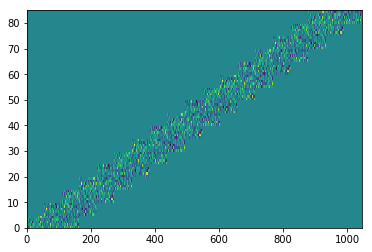

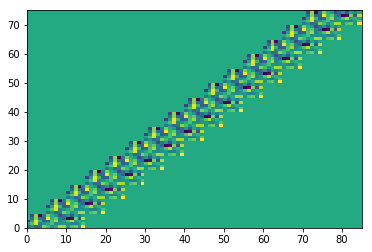

In [49]:
# Visualize the mf_matrix to confirm that it is block diagonal
plt.pcolormesh(MF_Matrix)
plt.show()
plt.pcolormesh(MF_Matrix2)
plt.show()

In [50]:
MX_Matrix = conv_net.makeMXMatrix((X[:,17513]), *conv_net.F[0].shape, max_length)

In [51]:
# Debugging for make MX and make MF functions (s1 and s2 should be equal)
s1 = MX_Matrix.dot(conv_net.F[0].flatten('F').reshape(-1, 1))
s2 = MF_Matrix.dot(X[:,17513].reshape(-1, 1))
print(np.allclose(s1,s2))

True


###### Gradient checking

In [52]:
# Construct MF Matrices
MFs = [conv_net.constructFilterMatrix(conv_net.F[0], conv_net.max_length)]
MFs.append(conv_net.constructFilterMatrix(conv_net.F[1], conv_net.nlen_list[0]))
P_batch, X_batch1, X_batch2 = conv_net.forwardPass(X[:,:100], MFs)
grad_F1, grad_F2, grad_W = conv_net.backwardPass(Y[:,:100], P_batch, X[:,:100], X_batch1, X_batch2, MFs)

In [53]:
grad_F1_approx, grad_F2_approx, grad_W_approx = conv_net.compute_grad_num_slow(X[:,:100], Y[:,:100])


100%|██████████████████████████████████████████| 18/18 [00:01<00:00,  9.06it/s]

 15%|██████▎                                    | 8/55 [00:00<00:01, 38.37it/s]D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)

100%|██████████████████████████████████████████| 55/55 [00:01<00:00, 38.70it/s]

In [54]:
errors1 = getRelativeErrors(grad_F1, grad_F1_approx)
errors2 = getRelativeErrors(grad_F2, grad_F2_approx)
errors3 = getRelativeErrors(grad_W, grad_W_approx)
print(np.max(errors1))
print(np.max(errors2))
print(np.max(errors3))

print(np.mean(errors1))
print(np.mean(errors2))
print(np.mean(errors3))

8.165441154216389e-06
6.400764004340535e-07
2.3077113589892306e-06
8.756918632779195e-08
2.3778036353764807e-08
6.320978737973386e-08


### Train using mini-batch gradient descent with momentum

In [57]:
rho = 0.9
epochs = 5
mini_batch_size = 100
decay_rate = 0.95
eta = 0.05
n_update = 500
np.random.seed(0)

filter_width_constants = [5, 3]
filter_numbers = [20, 20]
K = len(class_dictionary)
conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                   input_dim = d, nlen = max_length, he_init = True)

GDparams = Params(mini_batch_size, eta, epochs, decay_rate, rho)
results = conv_net.miniBatchGD(X_tr, Y_tr, GDparams, verbose = True, X_val = X_val, Y_val = Y_val, tol = 1e-10, n_update = n_update)

Starting state 
    Training cost: 5.8126829642800315
    Training accuracy: 0.03507702537958551
    Validation cost: 5.860580986991063
    Validation accuracy: 0.03093812375249501





  0%|                                                    | 0/5 [00:00<?, ?it/s]

Iteration 0
    Training cost: 5.616160170690379
    Training accuracy: 0.04361077247035354
    Validation cost: 5.668642054322005
    Validation accuracy: 0.04341317365269461
Iteration 0
    Training cost: 5.478315595207743
    Training accuracy: 0.06594259115593483
    Validation cost: 5.528162662511577
    Validation accuracy: 0.06487025948103792
Iteration 0
    Training cost: 6.4947515282928805
    Training accuracy: 0.0933724925191178
    Validation cost: 6.551942308488295
    Validation accuracy: 0.08582834331337326


D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


Iteration 0
    Training cost: 8.946437157311115
    Training accuracy: 0.10018840740330268
    Validation cost: 9.027503599457537
    Validation accuracy: 0.0968063872255489
Iteration 0
    Training cost: 11.89644440497915
    Training accuracy: 0.10018840740330268
    Validation cost: 12.001525778054027
    Validation accuracy: 0.09630738522954092
Iteration 0
    Training cost: 14.793433427936996
    Training accuracy: 0.10013299346115483
    Validation cost: 14.914158918161952
    Validation accuracy: 0.09630738522954092
Iteration 0
    Training cost: 17.537160589914887
    Training accuracy: 0.10013299346115483
    Validation cost: 17.670896262151096
    Validation accuracy: 0.09630738522954092
Iteration 0
    Training cost: 20.12718281980613
    Training accuracy: 0.10013299346115483
    Validation cost: 20.272313181957408
    Validation accuracy: 0.09630738522954092
Iteration 0
    Training cost: 22.565840963501742
    Training accuracy: 0.10013299346115483
    Validation cost: 2




 20%|████████▌                                  | 1/5 [04:05<16:20, 245.11s/it]

Iteration 1
    Training cost: 13.590286279144513
    Training accuracy: 0.10013299346115483
    Validation cost: 13.779206618916348
    Validation accuracy: 0.09630738522954092
Iteration 1
    Training cost: 8.556701219894686
    Training accuracy: 0.10107503047766818
    Validation cost: 8.712131824018352
    Validation accuracy: 0.0968063872255489
Iteration 1
    Training cost: 5.700652977465839
    Training accuracy: 0.10905463814695777
    Validation cost: 5.812498464074787
    Validation accuracy: 0.10578842315369262
Iteration 1
    Training cost: 4.19692993927948
    Training accuracy: 0.12540175108057186
    Validation cost: 4.272073184435518
    Validation accuracy: 0.12275449101796407
Iteration 1
    Training cost: 3.454039273359891
    Training accuracy: 0.14507370054305663
    Validation cost: 3.5160284430861948
    Validation accuracy: 0.13822355289421157
Iteration 1
    Training cost: 3.1163144930156714
    Training accuracy: 0.16114374376593152
    Validation cost: 3.168




 40%|█████████████████▏                         | 2/5 [08:18<12:28, 249.39s/it]

Iteration 2
    Training cost: 2.8802967918955127
    Training accuracy: 0.20835642247589495
    Validation cost: 2.9461804601187778
    Validation accuracy: 0.19461077844311378
Iteration 2
    Training cost: 2.9040797883209635
    Training accuracy: 0.21711182533525436
    Validation cost: 2.976834024491103
    Validation accuracy: 0.2025948103792415
Iteration 2
    Training cost: 2.979224068584311
    Training accuracy: 0.22209908012856033
    Validation cost: 3.060985415691254
    Validation accuracy: 0.2030938123752495
Iteration 2
    Training cost: 3.1045936576571695
    Training accuracy: 0.22636595367394435
    Validation cost: 3.1972430145854953
    Validation accuracy: 0.2055888223552894
Iteration 2
    Training cost: 3.2705221144446113
    Training accuracy: 0.22686467915327496
    Validation cost: 3.3748364769004944
    Validation accuracy: 0.2055888223552894
Iteration 2
    Training cost: 3.4732052653457495
    Training accuracy: 0.22426022387232628
    Validation cost: 3.5




 60%|█████████████████████████▊                 | 3/5 [12:30<08:20, 250.22s/it]

Iteration 3
    Training cost: 3.9216797862081414
    Training accuracy: 0.259614318962651
    Validation cost: 4.077914451847996
    Validation accuracy: 0.2375249500998004
Iteration 3
    Training cost: 3.7105271469206764
    Training accuracy: 0.28089327274742326
    Validation cost: 3.864676778899558
    Validation accuracy: 0.25998003992015967
Iteration 3
    Training cost: 3.5496872830673323
    Training accuracy: 0.29912445971406404
    Validation cost: 3.7022385800533013
    Validation accuracy: 0.28043912175648705
Iteration 3
    Training cost: 3.4293435863396398
    Training accuracy: 0.3142524659204256
    Validation cost: 3.5807563661878175
    Validation accuracy: 0.29291417165668665
Iteration 3
    Training cost: 3.342250824145221
    Training accuracy: 0.32494735675495956
    Validation cost: 3.492960172515444
    Validation accuracy: 0.3073852295409182
Iteration 3
    Training cost: 3.2832740701242042
    Training accuracy: 0.334755624515128
    Validation cost: 3.43374




 80%|██████████████████████████████████▍        | 4/5 [16:35<04:08, 248.96s/it]

Iteration 4
    Training cost: 2.985456359892642
    Training accuracy: 0.37060844508478336
    Validation cost: 3.130805012332317
    Validation accuracy: 0.3522954091816367
Iteration 4
    Training cost: 2.8661435796114536
    Training accuracy: 0.3785880527540729
    Validation cost: 3.0058518246238304
    Validation accuracy: 0.36227544910179643
Iteration 4
    Training cost: 2.779927525286514
    Training accuracy: 0.3829657541837526
    Validation cost: 2.915085107906686
    Validation accuracy: 0.3687624750499002
Iteration 4
    Training cost: 2.7216476762979687
    Training accuracy: 0.38435110273744877
    Validation cost: 2.853197717969333
    Validation accuracy: 0.3662674650698603
Iteration 4
    Training cost: 2.6866594194128157
    Training accuracy: 0.3829103402416048
    Validation cost: 2.8153443871809483
    Validation accuracy: 0.36327345309381237
Iteration 4
    Training cost: 2.6715713268762307
    Training accuracy: 0.37964091765488195
    Validation cost: 2.79825




100%|███████████████████████████████████████████| 5/5 [20:39<00:00, 247.86s/it]


